<a href="https://colab.research.google.com/github/Amaljayaranga/Autoencoders/blob/master/NNVae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

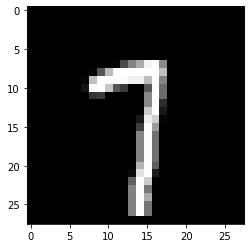

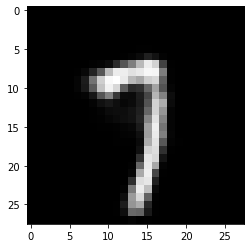

In [2]:
import torch
from torch import nn
from torch.autograd import Variable
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

dataset = MNIST('./data',transform=transforms.ToTensor(), download=True)
dataloader = DataLoader(dataset,batch_size=100,shuffle=True)


class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()

        self.fc1 = nn.Linear(28*28,400)
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fcmu = nn.Linear(100, 20)
        self.fcvar = nn.Linear(100, 20)

        self.fc4 = nn.Linear(20,100)
        self.fc5 = nn.Linear(100,200)
        self.fc6 = nn.Linear(200,400)
        self.fc7 = nn.Linear(400,28*28)

    def encode(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fcmu(x), self.fcvar(x)

    def decode(self,z):
        z = F.relu(self.fc4(z))
        z = F.relu(self.fc5(z))
        z = F.relu(self.fc6(z))
        z = self.fc7(z)
        return torch.sigmoid(z)

    def reparametrize(self,mu,var):
        std = torch.exp(0.5*var)
        eps = torch.rand_like(std)
        return mu + eps*std

    def forward(self,x):
        mu, var = self.encode(x)
        z = self.reparametrize(mu,var)
        return self.decode(z), mu, var


def loss_f(rx,x,mu,var):
    recons_loss = nn.MSELoss(reduction='sum')(rx,x)
    KLD = -0.5*torch.sum(1 + torch.log(var.pow(2)) - mu.pow(2) - var.pow(2))
    return   recons_loss + KLD


model = Model()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss = 0

train = False

if train:
    for epoch in range(100):
        for data in dataloader:
            img, _ = data
            img = img.view(img.size(0), -1)
            img = Variable(img)
            optimizer.zero_grad()
            rx, mu, var = model(img)
            #print(rx.size())
            loss = loss_f(rx, img, mu, var)

            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print('Epoch : ', epoch+1, 'Loss : ', loss.item()/len(img))

    torch.save(model, './nn_vae.pth')


if not train:
    model = torch.load('./nn_vae.pth')
    model.eval()

    img, _ = next(iter(dataloader))
    plt.imshow(img.numpy()[0].reshape(28,28), cmap='gray')
    plt.show()

    img = img.view(img.size(0), -1)
    img = Variable(img)
    #print(img.size())
    rx, mu, var = model(img)
    #print(output.size())
    plt.imshow(rx.detach().numpy()[0].reshape(28,28), cmap='gray')
    plt.show()

